VAE(Variational AutoEncoder) 모델

- Auto Encoder 개념을 활용한 생성 모델
    - auto encoder는 압축 > 복원 > output

- 압축할 때, 잠재 공간(z)에 확률 분포를 저장하여 평균과 분산 파라미터 생성

- input image X를 잘 설명하는 feature를 추출하여 latent vector z에 담고 이 z를 통해 X와 유사하지만 완전히 새로운 데이터를 생성해 내는 것

- 예를 들어 한국인의 얼굴을 그리기 위해 눈, 코, 입 등의 feature를 Latent vector z에 담고, 그 z를 이용해 그럴듯한 한국인의 얼굴을 그려내는 것


In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import backend as K

(x_tr, y_tr), (x_ts, y_ts) = mnist.load_data()
x_tr = x_tr.astype('float32') / 255.
x_ts = x_ts.astype('float32') / 255.
x_tr = np.reshape(x_tr,(len(x_tr), 28, 28, 1))
x_ts = np.reshape(x_ts,(len(x_ts), 28, 28, 1))



In [2]:
# K.shape 설명
a = [10,20,30]
print(K.shape(a))   # 1차원

b = [[10,20,30]]
print(K.shape(b))   # 1행 3열, 2차원

tf.Tensor([3], shape=(1,), dtype=int32)
tf.Tensor([1 3], shape=(2,), dtype=int32)


In [3]:
# K.exp 설명
# 밑이 자연상수 e인 지수함수(e^x)로 변환
K.exp(1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=2.7182817>

In [4]:
zdim = 32

def sampling(args):
    # 평균, 로그분산
    z_mean, z_log_var = args
    # epsilon : 임의의 실수값
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], zdim), mean=0.0, stddev=0.1)
    return z_mean+K.exp(0.5*z_log_var) * epsilon

encoder_input = Input(shape=(28,28,1))
x = Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1))(encoder_input)
x = Conv2D(64, (3,3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1))(x)
x = Flatten()(x)
z_mean = Dense(zdim)(x)
z_log_var = Dense(zdim)(x)
encoder_output = Lambda(sampling)([z_mean, z_log_var])
model_encoder = Model(encoder_input, [z_mean, z_log_var, encoder_output])
model_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     36928       ['conv2d_1[0][0]']               
                                                                                              

In [5]:
decoder_input = Input(shape=(zdim,))
x = Dense(3136)(decoder_input)
x = Reshape((7,7,64))(x)

x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same',strides=(1,1))(x)

decoder_output = x
model_decoder = Model(decoder_input, decoder_output)
model_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       1846

In [6]:
model_input = encoder_input
model_output = model_decoder(encoder_output)
model = Model(model_input, model_output)

reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(model_input, model_output), axis=(1,2)))
kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
total_loss = reconstruction_loss + kl_loss
model.add_loss(total_loss)

model.compile(optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     36928       ['conv2d_1[0][0]']               
                                                                                            

In [7]:
model.fit(x_tr, x_tr, epochs=5,batch_size=128,validation_data=(x_ts,x_ts))


Epoch 1/5
469/469 [==============================] - 43s 79ms/step - loss: 128.2902 - val_loss: 75.5306
Epoch 2/5
469/469 [==============================] - 35s 75ms/step - loss: 72.8431 - val_loss: 69.8897
Epoch 3/5
469/469 [==============================] - 37s 80ms/step - loss: 69.3106 - val_loss: 67.8090
Epoch 4/5
469/469 [==============================] - 35s 74ms/step - loss: 67.9549 - val_loss: 66.9341
Epoch 5/5
469/469 [==============================] - 35s 75ms/step - loss: 67.0850 - val_loss: 66.3889


1/1 [==============================] - 0s 19ms/step
2 1
1/1 [==============================] - 0s 22ms/step


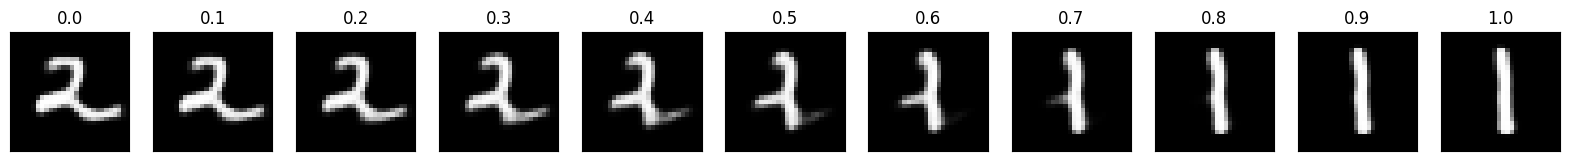

In [12]:
# random으로 2개 샘플 선택
i = np.random.randint(x_ts.shape[0])
j = np.random.randint(x_ts.shape[0])
x = np.array((x_ts[i], x_ts[j]))
z = model_encoder.predict(x)[2]   # encoder_output

print(y_ts[i], y_ts[j])

# 영배열
zz = np.zeros((11, zdim))    # 11 x 32

alpha = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for i in range(11):
    zz[i] = (1.0-alpha[i]) * z[0] + alpha[i] * z[1]    # z[0] z_mean , z[1] z_log_var

gen = model_decoder.predict(zz)


plt.figure(figsize=(20,4))

for i in range(11):
    plt.subplot(1,11,i+1)
    plt.imshow(gen[i].reshape(28,28),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(str(alpha[i]))